In [2]:
import polars as pl
import glob

In [2]:
file = glob.glob('./reviewETL/*.parquet')

In [3]:
df_lazy = pl.scan_parquet(file)

In [4]:
conteo_total = df_lazy.select(pl.len()).collect()
print(conteo_total)


shape: (1, 1)
┌──────────┐
│ len      │
│ ---      │
│ u32      │
╞══════════╡
│ 88487947 │
└──────────┘


In [5]:
df_lazy.collect_schema()

Schema([('gmap_id', String),
        ('name', String),
        ('rating', Int64),
        ('resp', Struct({'text': String, 'time': Int64})),
        ('text', String),
        ('time', Int64),
        ('user_id', String),
        ('fecha', Datetime(time_unit='ns', time_zone=None)),
        ('año', Int32),
        ('id_rev', String)])

In [6]:
df_anual = df_lazy.group_by('año').agg(pl.col('año').count().alias('cantidad')).collect()

# Mostrar el resultado
print(df_anual.sort('año'))

shape: (24, 2)
┌──────┬──────────┐
│ año  ┆ cantidad │
│ ---  ┆ ---      │
│ i32  ┆ u32      │
╞══════╪══════════╡
│ 1990 ┆ 44       │
│ 1999 ┆ 2        │
│ 2000 ┆ 2        │
│ 2001 ┆ 3        │
│ 2002 ┆ 33       │
│ …    ┆ …        │
│ 2017 ┆ 11306406 │
│ 2018 ┆ 21361698 │
│ 2019 ┆ 27100727 │
│ 2020 ┆ 16547480 │
│ 2021 ┆ 8122853  │
└──────┴──────────┘


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


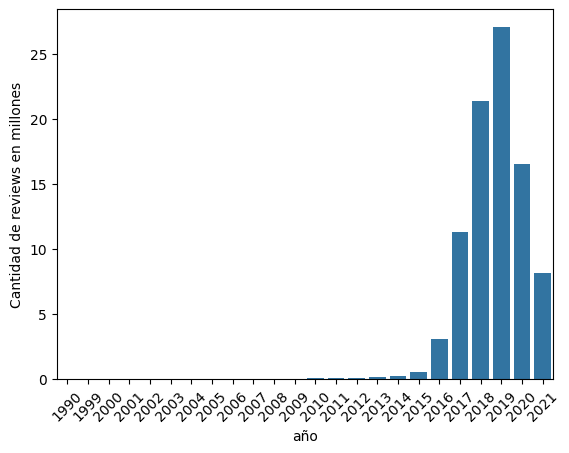

In [8]:
sns.barplot(x='año', y= df_anual['cantidad']/1000000,data=df_anual)
plt.ylabel('Cantidad de reviews en millones')
plt.xticks(rotation=45)
plt.show()

In [9]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
#import glob


In [10]:
#Crear sesión de spark
spk = SparkSession.builder \
    .config("spark.driver.port", "4040") \
    .config("spark.local.dir", "/run/media/hugo/06368a0d-700b-4ac5-9159-173c295dcaed/") \
    .config("spark.hadoop.fs.defaultFS", "file:///run/media/hugo/06368a0d-700b-4ac5-9159-173c295dcaed/") \
    .master("local[*]") \
    .appName("EDAReview") \
    .getOrCreate()
spk.sparkContext.setLogLevel("ERROR")

24/11/05 19:52:08 WARN Utils: Your hostname, hugo-81we resolves to a loopback address: 127.0.1.1; using 10.203.71.211 instead (on interface wlp0s20f3)
24/11/05 19:52:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/05 19:52:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/05 19:52:09 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/11/05 19:52:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [11]:
df_spk = spk.read.parquet('reviewETL')

In [12]:
df_spk = df_spk.filter(df_spk['text'] != 'nd')

In [13]:
df_spk.count()

49278065

In [14]:
# Guardar el DataFrame de PySpark en un archivo Parquet
df_spk.write.parquet("data.parquet")


InvalidOperationError: directory contained paths with different file extensions: \
                first path: data.parquet/._SUCCESS.crc, second path: data.parquet/part-00000-d2513b1e-57c8-4f00-ad2b-46de753acfda-c000.snappy.parquet. Please use a glob pattern to explicitly specify \
                which files to read (e.g. "dir/**/*", "dir/**/*.parquet")

In [4]:
files = glob.glob('./data.parquet/*.parquet')
# Leer el archivo Parquet con Polars
df_polars = pl.scan_parquet(files)

In [11]:
import spacy

ModuleNotFoundError: No module named 'spacy'

In [3]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/hugo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/hugo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
stopwords = nltk.corpus.stopwords.words('english') # Carga las stopwords en inglés

In [6]:
import re 

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [10]:
# Función de tokenización y stemming que se aplicará a cada fila
def procesar_texto(texto):
    # Reemplazar los caracteres que no sean letras por espacios
    texto = re.sub("[^a-zA-Z]", " ", str(texto))
    # Pasar todo a minúsculas
    texto = texto.lower()
    # Tokenizar para separar las palabras
    texto = nltk.word_tokenize(texto)
    # Eliminar las palabras de menos de 2 letras
    texto = [palabra for palabra in texto if len(palabra) > 2]
    # Sacar las stopwords
    texto = [palabra for palabra in texto if palabra not in stopwords]
    # Aplicar stemming
    texto = [stemmer.stem(palabra) for palabra in texto]
    # Volver a unir el texto
    return " ".join(texto)

# Aplicar la función con apply() en modo lazy
df_polars = df_polars.with_columns(
    pl.col("text").map(procesar_texto).alias("text0")
)

# Materializar el resultado
df_resultado = df_polars.collect()

# Imprimir el resultado
print(df_resultado)


AttributeError: 'Expr' object has no attribute 'map'

In [9]:
df_polars.collect_schema()

Schema([('gmap_id', String),
        ('name', String),
        ('rating', Int64),
        ('resp', Struct({'text': String, 'time': Int64})),
        ('text', String),
        ('time', Int64),
        ('user_id', String),
        ('fecha', Datetime(time_unit='ns', time_zone=None)),
        ('año', Int32),
        ('id_rev', String)])